In [139]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a + b*x

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

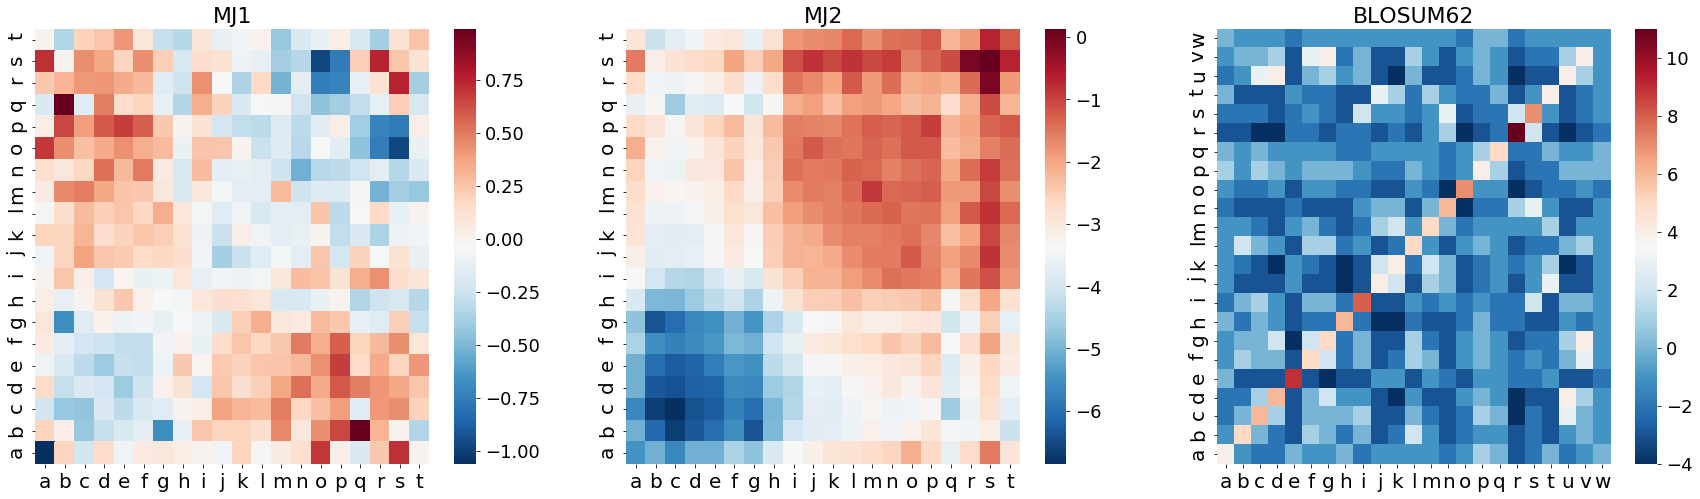

In [2]:
M1 = np.loadtxt('../Text_files/MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt('../Text_files/MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt('../Text_files/BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']

fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])

fig.savefig('../Figures/Energy_matrices.png')

In [3]:
%%time
n_seq = 400000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")


CPU times: user 3.76 s, sys: 328 ms, total: 4.09 s
Wall time: 4.13 s


In [4]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy, Sequences[0].energy

('odsadmgao',
 'mdnbdmgat',
 4,
 -3.1000000000000014,
 -3.1200000000000014,
 -0.01999999999999999,
 -5.500000000000001)

In [4]:
fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences, bins = 100, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(n_seq))
plt.close()


## Stochastic Simulation

In [45]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.2
R=6
beta = 1
gamma = 1
T = 5
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = 0)
Model.Gillespie()


CPU times: user 16.8 s, sys: 4.89 s, total: 21.7 s
Wall time: 21.9 s


In [48]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energy_Matrix=M2, Alphabet = Alphabet, title = 'MJ 1996', ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 100, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))
plt.close()


In [9]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Entropy_%d.png'%(counter))
plt.close()


In [10]:
Model.activation_time_series.shape

(200, 1168)

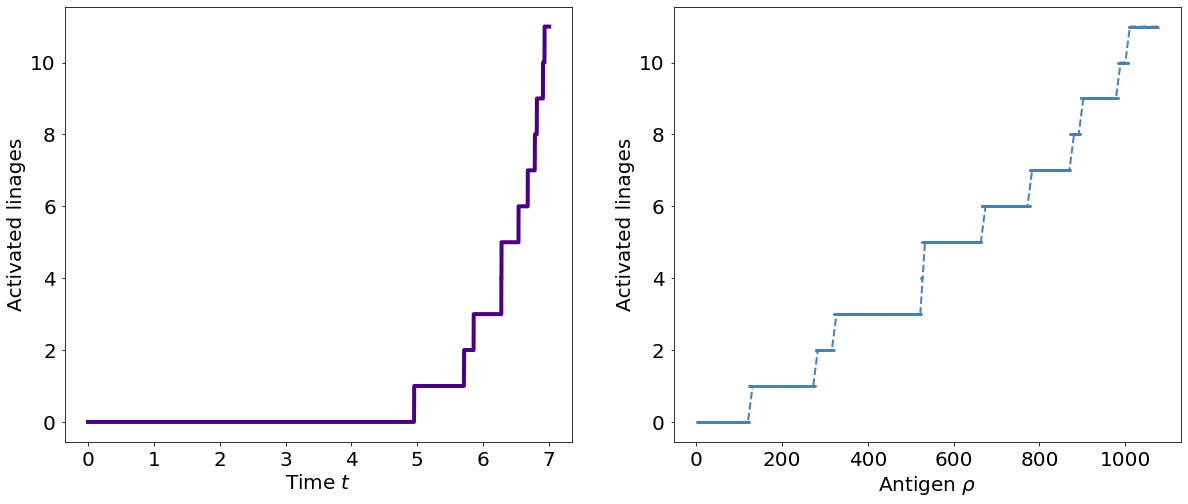

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(1, np.max(Model.antigen_time_series), 100)
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



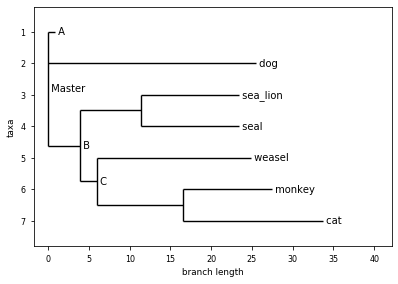

In [21]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

# Ensemble of systems

## Distribution of linage sizes

In [108]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.4
R=6
beta = 1
gamma = 1
T = 5
master_Sequence_energy = 14

#_____ Choose one of the following____________________________________
#activated_linages_size_t = []
#final_antigen_concentration = []
activated_linages_size_t = pickle.load( open( "../Text_files/activated_linages_size_t2.pkl", "rb" ) )
final_antigen_concentration = pickle.load( open( "../Text_files/final_antigen_concentration2.pkl", "rb" ) )
#_____________________________________________________________________

for i in range(1000):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
    Model.Gillespie()
    if(i%100==0):
        print(i, '...')
        print(Model.time_series[-1], Model.antigen_time_series[-1])
    activated_linages_size_t = np.append(activated_linages_size_t, [Model.linages_time_series[i,-1] for i in range(n_linages) if Model.Sequences[i].active])
    final_antigen_concentration = np.append(final_antigen_concentration, Model.antigen_time_series[-1])

pickle.dump(activated_linages_size_t, open( "../Text_files/activated_linages_size_t2.pkl", "wb" ) )
pickle.dump(final_antigen_concentration, open( "../Text_files/final_antigen_concentration2.pkl", "wb" ) )

print(len(activated_linages_size_t))

0 ...
5.0004907254718916 2377
100 ...
5.0008793915718135 2510
200 ...
5.000059442009694 2972
300 ...
5.000164688019771 3226
400 ...
5.000043255746261 2154
500 ...
5.000253343165059 2484
600 ...
5.000027792738666 2368
700 ...
5.000634445577475 3639
800 ...
5.0000986904339975 3318
900 ...
5.000468410129668 3060
19622
CPU times: user 4h 27min 49s, sys: 1h 16min 27s, total: 5h 44min 16s
Wall time: 5h 45min 28s


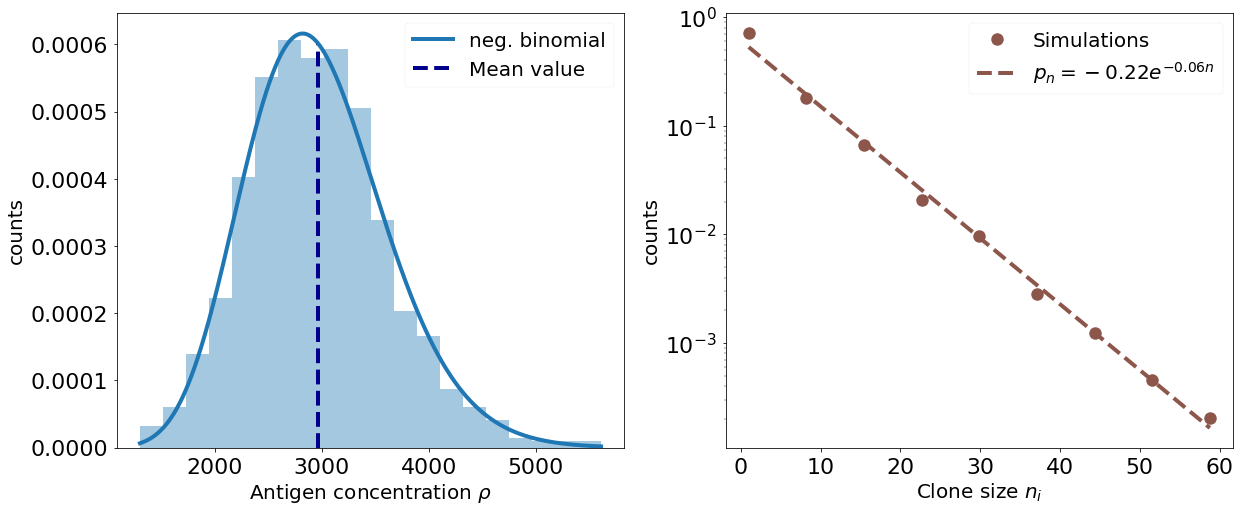

In [172]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))

#_______________________________________________________________________________________________________________

final_antigen_concentration = pickle.load( open( "../Text_files/final_antigen_concentration2.pkl", "rb" ) )

x = np.array(range(int(min(final_antigen_concentration)) , int(max(final_antigen_concentration))))
p = np.exp(-1*5)

ax[0].hist(final_antigen_concentration, bins = 20, density = True, alpha = 0.4)
ax[0].plot(x, sc.comb(x-1, x-20)*p**(20)*(1-p)**(x-20), color = 'tab:blue', linewidth = 4, ms=8, label='neg. binomial')
ax[0].vlines(20*np.exp(5), 0, sc.comb(20*np.exp(5)-1, 20*np.exp(5)-20)*p**(20)*(1-p)**(20*np.exp(5)-20), linestyle = 'dashed', linewidth = 4, color = 'darkblue', label = 'Mean value')
ax[0].set_xlabel(r'Antigen concentration $\rho$', fontsize = 20)
ax[0].set_ylabel(r'counts', fontsize = 20)
ax[0].tick_params(labelsize = 22)
ax[0].legend(loc = 0, fontsize = 20)
#_______________________________________________________________________________________________________________

activated_linages_size_t = pickle.load( open( "../Text_files/activated_linages_size_t2.pkl", "rb" ) )

data_activated_linages = np.histogram(activated_linages_size_t, bins = np.logspace(1,np.log10(np.max(activated_linages_size_t)),10))
data_activated_linages2 = np.histogram(activated_linages_size_t, bins = np.linspace(1,np.max(activated_linages_size_t),10))

#Cumulative
#ax[1].plot(data_activated_linages[1][:-1], 1-np.cumsum(data_activated_linages[0])/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:red')
#ax[1].plot(data_activated_linages[1][:-1], (data_activated_linages[0][0]/np.sum(data_activated_linages[0]))*(data_activated_linages[1][:-1])**(-1), linestyle = '--', color = 'tab:red', label = r'$p\sim n_i^{-1}$')

#Distribution
#ax[1].plot(data_activated_linages[1][:-1], data_activated_linages[0]/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')
ax[1].plot(data_activated_linages2[1][:-1], data_activated_linages2[0]/np.sum(data_activated_linages2[0]), marker = '.', ms = 25, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')
#ax[1].plot(data_activated_linages[1][:-1], 100*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown', label = r'$p\sim n_i^{-2}$')
#ax[1].plot(data_activated_linages[1][:-1], 100000*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown')

popt, pcov = curve_fit(linear_func, data_activated_linages2[1][:-1], np.log10(data_activated_linages2[0]/np.sum(data_activated_linages2[0])), p0 = (0, -5/40))

ax[1].plot(data_activated_linages2[1][:-1], 10**(linear_func(data_activated_linages2[1][:-1], *popt)), linestyle = '--', linewidth = 4, color = 'tab:brown', label = r'$p_n= %.2fe^{%.2fn}$'%(popt[0], popt[1]))

ax[1].set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax[1].set_ylabel(r'counts', fontsize = 20)
ax[1].tick_params(labelsize = 22)
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc = 0, fontsize = 20)

#_______________________________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Linages_size_distribution_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Linages_size_distribution_%d.png'%(counter))
#plt.close()


## Activation rate

In [150]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.4
R=6
beta = 1
gamma = 1
T = 5
master_Sequence_energy = 14

activation_time_series_rho = np.zeros(40)
activation_time_series_rho_2 = np.zeros(40)
activation_time_series_t = np.zeros(40)
max_rho = 1e3
rho_new = np.linspace(20, max_rho, 40)
t_new = np.linspace(0, 5, 40)

counter = 0
for i in range(1):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
    Model.Gillespie()
    print(Model.activation_time_series)
    if(i%10==0):
        print(i, '...')
        print(Model.time_series[-1], Model.antigen_time_series[-1])
    activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
    f_rho = interp1d(Model.antigen_time_series, activation_time_series_i)
    f_t = interp1d(Model.time_series, activation_time_series_i)
    activation_time_series_rho = activation_time_series_rho + f_rho(rho_new)
    activation_time_series_rho_2 = activation_time_series_rho_2 + (f_rho(rho_new))**2
    activation_time_series_t = activation_time_series_t + f_t(t_new)
    counter += 1
    #else:
        #print('The maximum antigen was:', Model.antigen_time_series[-1])
        
activation_time_series_rho = activation_time_series_rho/(counter)
activation_time_series_rho_2 = (activation_time_series_rho_2)/(counter)
activation_time_series_rho_var = activation_time_series_rho_2-activation_time_series_rho**2
activation_time_series_t = activation_time_series_t/counter

#pickle.dump(activation_time_series_rho, open( "../Text_files/activation_time_series_rho.pkl", "wb" ) )
#pickle.dump(activation_time_series_rho_var, open( "../Text_files/activation_time_series_rho_var.pkl", "wb" ) )
#pickle.dump(activation_time_series_t, open( "../Text_files/activation_time_series_t.pkl", "wb" ) )

print(counter)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 ...
5.000505275083418 2720
1
CPU times: user 15.6 s, sys: 4.39 s, total: 20 s
Wall time: 21.2 s


In [153]:
activation_time_series_rho

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

-1.7530906647767526 0.4218331847047946
0.00523598785512418 0.0008619763739012886
0.000863868628606757


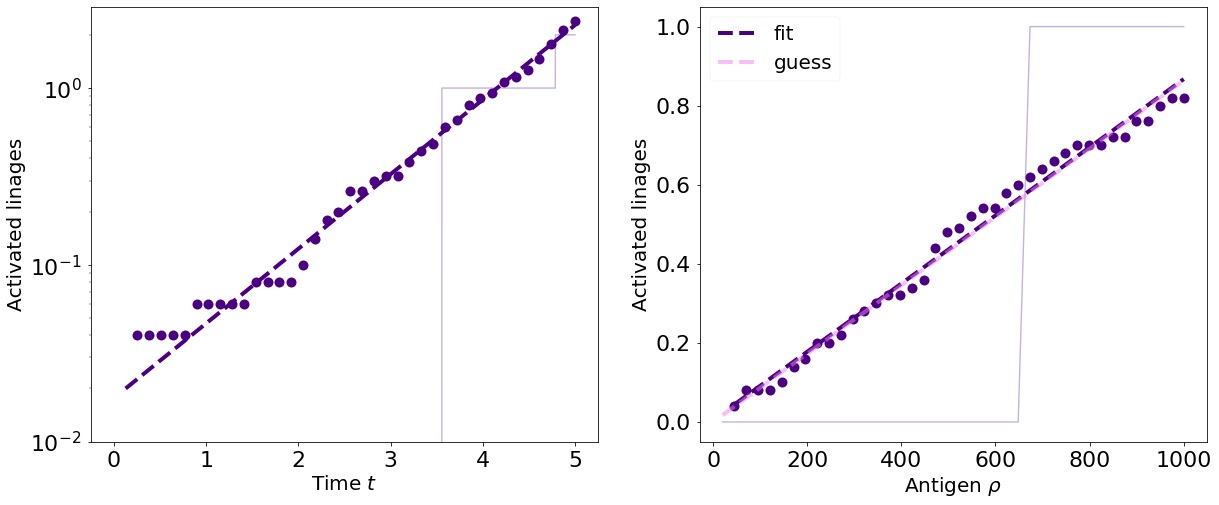

In [213]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
gamma = 1
R_0 = 12

#________________________________________________________________________________________

t_new = np.linspace(0, 5, 40)
activation_time_series_t = pickle.load( open( "../Text_files/activation_time_series_t.pkl", "rb" ) )
popt, pcov = curve_fit(linear_func, t_new[1:], np.log10(activation_time_series_t[1:]))

ax[0].plot(t_new[1:], activation_time_series_t[1:], '.', ms = 20, linewidth = 4, color = 'indigo')
ax[0].plot(t_new[1:], 10**linear_func(t_new[1:], *popt), '--', ms = 20, linewidth = 4, color = 'indigo')
ax[0].plot(Model.time_series, activation_time_series_i, color = 'indigo', alpha = 0.3)
print(*popt)
#ax[0].fill_between(rho_new, activation_time_series_rho-np.sqrt(activation_time_series_rho_var), activation_time_series_rho + np.sqrt(activation_time_series_rho_var), color='indigo', alpha = 0.3)
#ax[0].plot(rho_new, (1/gamma)*(rho_new*np.exp(-12-(-5))-1))
#ax[0].plot(rho_new, 4.4*(rho_new*np.exp(-12-(-5.5))))
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 22)
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(0.01, max(activation_time_series_t[1:]*1.2))
#ax[0].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

rho_new = np.linspace(20, max_rho, 40)
activation_time_series_rho = pickle.load( open( "../Text_files/activation_time_series_rho.pkl", "rb" ) )
activation_time_series_rho_var = pickle.load( open( "../Text_files/activation_time_series_rho_var.pkl", "rb" ) )
popt, pcov = curve_fit(linear_func, rho_new[1:], activation_time_series_rho[1:])

ax[1].plot(rho_new[1:], activation_time_series_rho[1:], '.', ms = 20, linewidth = 4, color = 'indigo')
ax[1].plot(rho_new[1:], linear_func(rho_new[1:], *popt), '--', ms = 20, linewidth = 4, color = 'indigo', label ='fit')
ax[1].plot(rho_new, f_rho(rho_new), color = 'indigo', alpha = 0.3)
ax[1].plot(rho_new, linear_func(rho_new, 0, np.exp(5-14)*7 ), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')
print(*popt)
#ax[1].fill_between(rho_new, activation_time_series_rho-np.sqrt(activation_time_series_rho_var), activation_time_series_rho + np.sqrt(activation_time_series_rho_var), color='indigo', alpha = 0.3)
#ax[1].plot(rho_new, (1/gamma)*(rho_new*np.exp(-12-(-5))-1))
#ax[1].plot(rho_new, 4.4*(rho_new*np.exp(-12-(-5.5))))
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 22)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Activation_rate_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Activation_rate_%d.png'%(counter))
#plt.close()
print(np.exp(5-14)*7)

(0.5, 100000.0)

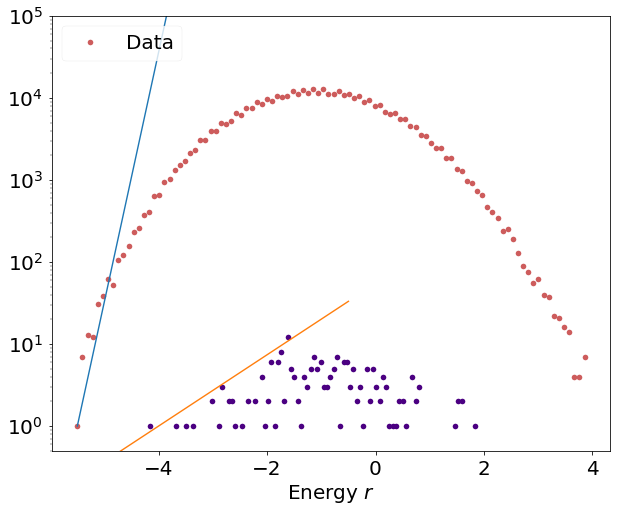

In [208]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
#___________________________________________
energies = plot_histogram_energy(Sequences = Sequences, bins = 100, ax = ax)
r_array = np.linspace(np.min(energies), np.min(energies)+5, 50)
r_array_2 = np.linspace(-4, -2, 50)
ax.plot(r_array, 1*np.exp(7*(r_array+5.5)))
#___________________________________________
Sub_Sequences = np.random.choice(Sequences, n_linages)
sub_energies = np.array([i.energy for i in Sub_Sequences])
data_energies = np.histogram(sub_energies, bins=100)
ax.plot(data_energies[1][0:-1], data_energies[0], linewidth = 4, color = 'indigo', label = 'Data', linestyle = '', marker = 'o')
ax.plot(r_array, np.exp(1*(r_array+4)))
#___________________________________________   
#ax.set_xlim(np.min(energies)-0.1, np.min(energies)+2)
ax.set_ylim(0.5, 1e5)

In [209]:
range_en = np.max(sub_energies)- np.min(sub_energies)
print(np.min(sub_energies))

-4.16


## Detection time

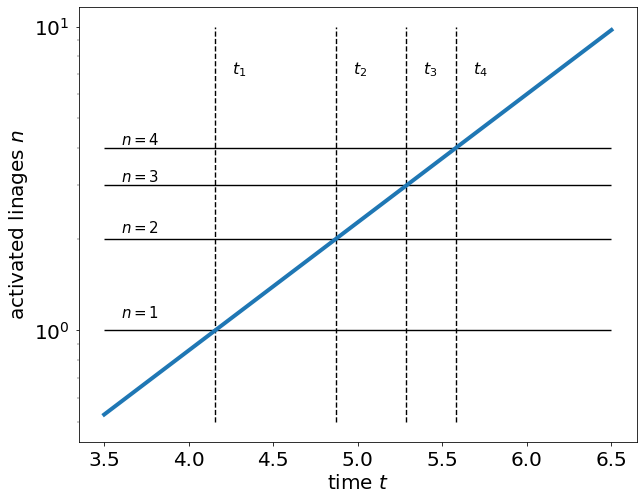

In [185]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

t = np.linspace(3.5, 6.5, 50)
N_b = 10**(-1.7530906647767526)*10**(0.4218331847047946*t)

ax.plot(t, N_b, linewidth = 4)

ax.hlines([1, 2, 3, 4], 3.5, 6.5)
ax.vlines(np.log10(np.array([1,2,3,4])/(10**(-1.7530906647767526)))/(0.4218331847047946), .5, 10, linestyle = 'dashed')

ax.text(3.6,1.1, r'$n = 1$', fontsize = 15)
ax.text(3.6,2.1, r'$n = 2$', fontsize = 15)
ax.text(3.6,3.1, r'$n = 3$', fontsize = 15)
ax.text(3.6,4.1, r'$n = 4$', fontsize = 15)

ax.text(np.log10(np.array([1])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_1$', fontsize = 16)
ax.text(np.log10(np.array([2])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_2$', fontsize = 16)
ax.text(np.log10(np.array([3])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_3$', fontsize = 16)
ax.text(np.log10(np.array([4])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_4$', fontsize = 16)

#ax.text(0, 20, r'$t_n \approx \ln{\left(\frac{n}{UR}\right)} + R_0$', fontsize = 25)
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'activated linages $n$', fontsize = 20)
ax.set_yscale('log')
ax.tick_params(labelsize = 20)
#ax.legend(fontsize = 20)
fig.savefig('../Figures/Activation_times.png')


In [8]:
Sequences2 = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(100), "rb" ) )

fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences2, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences2, bins = 100, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(100))
plt.close()



6.0

In [186]:
np.exp(-5)

0.006737946999085467